# Fully-Connected Neural Nets
*Complete this exercise and enclude results and output graphs along with desribtions of the model and development method in the assignment submission.

In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [3]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from classifiers import TwoLayerNet
from classifiers.Deep_learning_course.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from classifiers.Deep_learning_course.solver import Solver
from classifiers.Deep_learning_course.layers import *
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del HAM_train_data
   del HAM_val_data
   del HAM_test_data
   print('Clear previously loaded data.')
except:
   pass


# Load the training and tuning datasets.
os.chdir(os.path.join(os.getcwd(), 'datasets/HAM_modified'))
HAM_train_data = np.load('HAM_train.npz',allow_pickle=True)
HAM_val_data = np.load('HAM_val.npz',allow_pickle=True)
HAM_test_data = np.load('HAM_test.npz',allow_pickle=True)
os.chdir(os.path.join(os.getcwd(), '../..'))

#load and print header to view some info on the data and example data
header = HAM_train_data['header']
print('\n')
print(header)
print('\n')
print(HAM_train_data['images'][0].shape,HAM_train_data['meta'][0][:],'label: ',HAM_train_data['labels'][0])
print('\n')
X_train, y_train, train_meta = HAM_train_data['images'], HAM_train_data['labels'], HAM_train_data['meta']

X_val, y_val, val_meta = HAM_val_data['images'], HAM_val_data['labels'], HAM_val_data['meta']

X_test, y_test, test_meta = HAM_test_data['images'], HAM_test_data['labels'], HAM_test_data['meta']

#labels are of type np.float32 but need to be converted into uint 8 for use for slicing later
y_train = np.array([int(i) for i in y_train])
y_val = np.array([int(i) for i in y_val])
y_test = np.array([int(i) for i in y_test])

# shuffle
train_arr = list(zip(X_train, y_train))
random.shuffle(train_arr)

X_train, y_train = zip(*train_arr)
X_train = np.array(X_train)
y_train = np.array(y_train)

val_arr = list(zip(X_val, y_val))
random.shuffle(val_arr)

X_val, y_val = zip(*val_arr)
X_val = np.array(X_val)
y_val = np.array(y_val)

test_arr = list(zip(X_test, y_test))
random.shuffle(test_arr)

X_test, y_test = zip(*test_arr)
X_test = np.array(X_test)
y_test = np.array(y_test)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Training meta info shape: ', train_meta.shape)
print('\n')
print('Val data shape: ', X_val.shape)
print('Val labels shape: ', y_val.shape)
print('Val meta info shape: ', val_meta.shape)
print('\n')
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Test meta info shape: ', test_meta.shape)



['image_array' 'image_id' 'dx' 'dx_type' 'age' 'sex' 'localization']


(48, 48, 3) ['ISIC_0028005' 'nv' 'follow_up' '45.0' 'male' 'trunk'] label:  2.0


Training data shape:  (13932, 48, 48, 3)
Training labels shape:  (13932,)
Training meta info shape:  (13932, 6)


Val data shape:  (2821, 48, 48, 3)
Val labels shape:  (2821,)
Val meta info shape:  (2821, 6)


Test data shape:  (2866, 48, 48, 3)
Test labels shape:  (2866,)
Test meta info shape:  (2866, 6)


Number of classes = 3


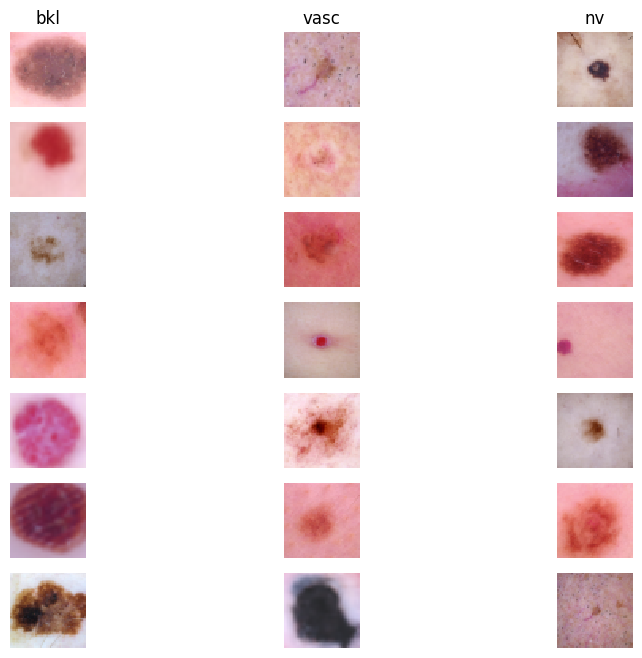

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
# we are going to be classifying three different types of 
# skin lesion on images sampled and modified from the HAM10000 data-set:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T 


class_dict = {'bkl':'benign keratosis-like lesions', 
               'vasc':'vascular lesions', 
               'nv':'melanocytic nevi'}


num_classes = len(class_dict.keys())

print('Number of classes = {}'.format(num_classes))

samples_per_class = 7
for y, cls in enumerate(class_dict.keys()):
    idxs = np.where(train_meta[:] == cls)[0]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (13932, 6912)
Validation data shape:  (2821, 6912)
Test data shape:  (2866, 6912)


# Affine layer: forward
Open the file `classifiers/Deep_learning_course/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [8]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [9]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [10]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [11]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


**Inline Question**

Consider the following for inclusion in the report:

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU




# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `deep_learningE22/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [12]:
from classifiers.Deep_learning_course.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `/layers.py`. These should be similar to what you implemented in `classifiers/softmax.py` and `classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [16]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.3025458445007376
dx error:  8.234144091578429e-09


# Two-layer network
Open the file `classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [29]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.20e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver
Open the file `classifiers/Deep_learning_course/solver.py` and read through it to familiarize yourself with the API. You also need to implement the `sgd` function in `classifiers/Deep_learning_course/optim.py`. After doing so, use a `Solver` instance to train a `TwoLayerNet'.

In [41]:
input_size = 48 * 48 * 3
hidden_size = 50
num_classes = 3
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test
}
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                    'learning_rate': 1e-4,
                },
                lr_decay=0.95,
                num_epochs=5, batch_size=200,
                print_every=100)
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 345) loss: 1.109257
(Epoch 0 / 5) train acc: 0.315000; val_acc: 0.305565
(Epoch 1 / 5) train acc: 0.592000; val_acc: 0.507976
(Iteration 101 / 345) loss: 0.967751
(Epoch 2 / 5) train acc: 0.368000; val_acc: 0.398795
(Iteration 201 / 345) loss: 0.920088
(Epoch 3 / 5) train acc: 0.575000; val_acc: 0.591634
(Epoch 4 / 5) train acc: 0.678000; val_acc: 0.721730
(Iteration 301 / 345) loss: 0.829185
(Epoch 5 / 5) train acc: 0.483000; val_acc: 0.481035


# Debug the training
Your results on the validation set may not be good in comparison to the training data.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

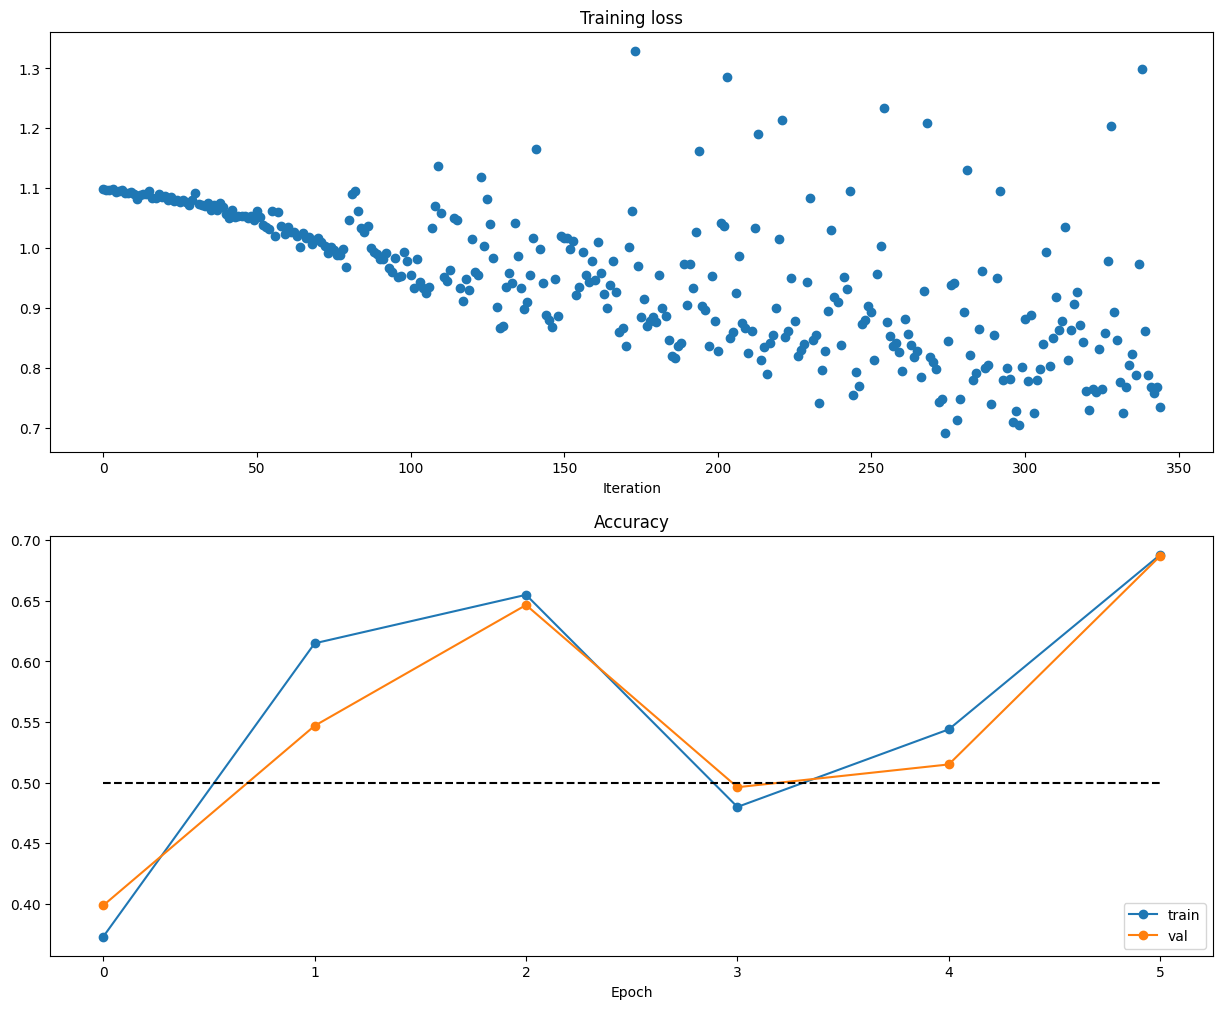

In [35]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

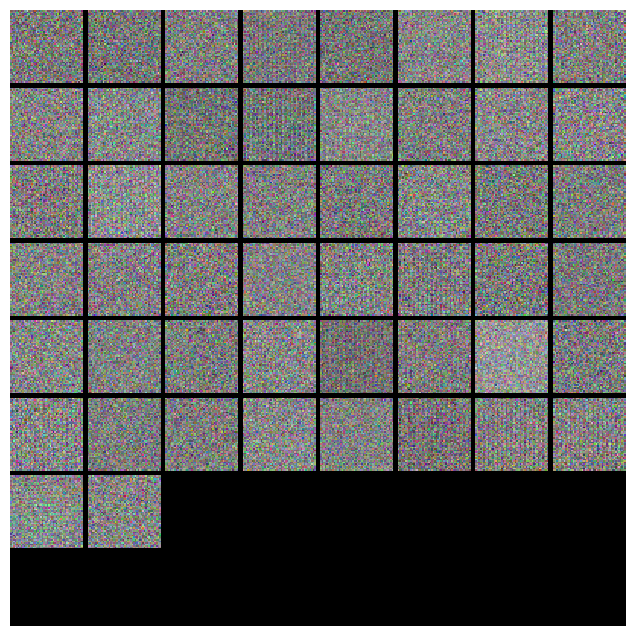

In [36]:
from classifiers.Deep_learning_course.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 48, 48, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Tune your hyperparameters

**What's going on?**. If the loss in the visualization above is decreasing more or less linearly, it may suggest that the learning rate is too low. Moreover, if there is no gap between the training and validation accuracy, it suggest that the model we used has low capacity, and that we should increase its size. Although with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Experiment**: You goal in this exercise is to get as good of a result on the modfied, three class HAM dataset as possible with a fully-connected Neural Network. Feel free implement your own techniques (e.g. dataaugmentation, dimensionality reduction, using different solvers)

In [38]:
import math


best_model = None
best_val = 0


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test
}

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
learning_rate_steps = 3
learning_rate_step_size = (learning_rates[1] - learning_rates[0]) / learning_rate_steps

regularization_strengths = [2.5e4, 5e4]
regularization_strength_steps = 3
regularization_strength_step_size = (regularization_strengths[1] - regularization_strengths[0]) / regularization_strength_steps

hidden_sizes = [30, 150]
hidden_size_steps = 3
hidden_size_step_size = math.floor((hidden_sizes[1] - hidden_sizes[0]) / hidden_size_steps)

number_epochs = [3, 20]
number_epoch_steps = 3
number_epoch_step_size = math.floor((number_epochs[1] - number_epochs[0]) / number_epoch_steps)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr_step in range(learning_rate_steps):
    for rs_step in range(regularization_strength_steps):
        for hs_step in range(hidden_size_steps):
            for ne_step in range(number_epoch_steps):
                lr = lr_step * learning_rate_step_size + learning_rates[0]
                rs = rs_step * regularization_strength_step_size + regularization_strengths[0]
                hs = hs_step * hidden_size_step_size + hidden_sizes[0]
                ne = ne_step * number_epoch_step_size + number_epochs[0]
                print(f"Iteration with following params: lr - {lr} | rs - {rs} | hs - {hs} | ne - {ne}")

                model = TwoLayerNet(input_size, hs, num_classes, reg=rs)
                solver = None

                solver = Solver(model, data,
                                update_rule='sgd',
                                optim_config={
                                    'learning_rate': lr,
                                },
                                lr_decay=0.95,
                                num_epochs=ne, batch_size=200,
                                print_every=100)
                solver.train()

                val_accuracy = solver.val_acc_history[-1]

                if val_accuracy > best_val:
                    best_val = val_accuracy
                    best_model = model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Iteration with following params: lr - 1e-07 | rs - 25000.0 | hs - 30 | ne - 3
(Iteration 1 / 207) loss: 2599.214713
(Epoch 0 / 3) train acc: 0.288000; val_acc: 0.288196
(Epoch 1 / 3) train acc: 0.282000; val_acc: 0.288196
(Iteration 101 / 207) loss: 1588.228378
(Epoch 2 / 3) train acc: 0.300000; val_acc: 0.289968
(Iteration 201 / 207) loss: 1002.218519
(Epoch 3 / 3) train acc: 0.298000; val_acc: 0.289614
Iteration with following params: lr - 1e-07 | rs - 25000.0 | hs - 30 | ne - 8
(Iteration 1 / 552) loss: 2597.562022
(Epoch 0 / 8) train acc: 0.398000; val_acc: 0.365828
(Epoch 1 / 8) train acc: 0.332000; val_acc: 0.379653
(Iteration 101 / 552) loss: 1587.219994
(Epoch 2 / 8) train acc: 0.385000; val_acc: 0.388515
(Iteration 201 / 552) loss: 1001.585283
(Epoch 3 / 8) train acc: 0.395000; val_acc: 0.394541
(Epoch 4 / 8) train acc: 0.421000; val_acc: 0.398086
(Iteration 301 / 552) loss: 654.811570
(Epoch 5 / 8) train acc: 0.387000; val_acc: 0.399504
(Iteration 401 / 552) loss: 440.854722


# Test your model!
Run your best model on the validation and test sets. 

In [39]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.4640198511166253


In [42]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.4344033496161898


## Inline Question: 

Consider the following for inclusion in your report:

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? 

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

